# 人才流失预测

## 一、导入第三方包

In [32]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import load
import joblib

import sklearn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, StackingRegressor, StackingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
import time

# 测试集预测
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

np.__version__, pd.__version__, sklearn.__version__, xgb.__version__

('2.2.6', '2.3.3', '1.7.2', '3.1.2')

# 二、数据加载

In [4]:
# load train data
train_data = pd.read_csv('../data/train.csv')
df = pd.DataFrame(train_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Attrition                 1100 non-null   int64 
 1   Age                       1100 non-null   int64 
 2   BusinessTravel            1100 non-null   object
 3   Department                1100 non-null   object
 4   DistanceFromHome          1100 non-null   int64 
 5   Education                 1100 non-null   int64 
 6   EducationField            1100 non-null   object
 7   EmployeeNumber            1100 non-null   int64 
 8   EnvironmentSatisfaction   1100 non-null   int64 
 9   Gender                    1100 non-null   object
 10  JobInvolvement            1100 non-null   int64 
 11  JobLevel                  1100 non-null   int64 
 12  JobRole                   1100 non-null   object
 13  JobSatisfaction           1100 non-null   int64 
 14  MaritalStatus           

## 三、数据分析

### 3.1 读取数据和打印数据

In [3]:
# 把数据集分为数值型和字符串型
num_cols = df.select_dtypes(include=['int64'])
str_cols = df.select_dtypes(include=['object'])

In [4]:
# 查看数值型前30行
num_cols.head(30)

,Attrition,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0,37,1,4,77,1,2,2,3,5993,...,3,80,1,7,2,4,7,5,0,7
1,0,54,1,4,1245,4,3,3,3,10502,...,1,80,1,33,2,1,5,4,1,4
2,1,34,7,3,147,1,1,2,3,6074,...,4,80,0,9,3,3,9,7,0,6
3,0,39,1,1,1026,4,2,4,4,12742,...,3,80,1,21,3,3,21,6,11,8
4,1,28,1,3,1111,1,2,1,2,2596,...,1,80,2,1,2,3,1,0,0,0
5,0,24,4,1,1445,4,3,2,3,4162,...,3,80,2,5,3,3,5,4,0,3
6,0,29,9,5,455,2,2,1,4,3983,...,3,80,0,4,2,3,3,2,2,2
7,0,36,2,2,513,2,2,3,3,7596,...,2,80,2,10,2,3,10,9,9,0
8,0,33,4,4,305,3,2,1,2,2622,...,4,80,0,7,3,3,3,2,1,1
9,0,34,2,4,1383,3,3,2,4,6687,...,4,80,0,14,2,4,14,11,4,11


In [5]:
num_cols.columns

Index(['Attrition', 'Age', 'DistanceFromHome', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [9]:
# 查看字符串型前30行
str_cols.head(30)

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Divorced,Y,No
1,Travel_Frequently,Research & Development,Life Sciences,Female,Manufacturing Director,Divorced,Y,No
2,Travel_Frequently,Research & Development,Life Sciences,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Rarely,Research & Development,Life Sciences,Female,Manufacturing Director,Married,Y,No
4,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Divorced,Y,No
5,Travel_Rarely,Sales,Medical,Female,Sales Executive,Married,Y,Yes
6,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,No
7,Travel_Rarely,Sales,Medical,Male,Sales Executive,Married,Y,No
8,Travel_Rarely,Research & Development,Medical,Female,Research Scientist,Married,Y,No
9,Travel_Rarely,Research & Development,Technical Degree,Female,Healthcare Representative,Single,Y,No


In [8]:
str_cols.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

### 3.2 绘图可视化

In [11]:
# 定义列元素频次统计函数
def count_the_cols(df: pd.DataFrame):
    for col in df:
        print(f'\n----- {col} -----')
        print(df[col].value_counts())


In [10]:
# 查看字符串星中出现的列名的频次
count_the_cols(str_cols)


----- BusinessTravel -----
BusinessTravel
Travel_Rarely        787
Travel_Frequently    205
Non-Travel           108
Name: count, dtype: int64

----- Department -----
Department
Research & Development    727
Sales                     331
Human Resources            42
Name: count, dtype: int64

----- EducationField -----
EducationField
Life Sciences       462
Medical             337
Marketing           127
Technical Degree     92
Other                63
Human Resources      19
Name: count, dtype: int64

----- Gender -----
Gender
Male      653
Female    447
Name: count, dtype: int64

----- JobRole -----
JobRole
Sales Executive              247
Research Scientist           221
Laboratory Technician        205
Manufacturing Director       101
Healthcare Representative    100
Manager                       80
Sales Representative          57
Research Director             56
Human Resources               33
Name: count, dtype: int64

----- MaritalStatus -----
MaritalStatus
Married     500
Si

In [12]:
#查看数值型中出现的列名的频次
count_the_cols(num_cols)


----- Attrition -----
Attrition
0    922
1    178
Name: count, dtype: int64

----- Age -----
Age
35    59
29    55
36    55
34    53
30    48
31    48
33    47
32    47
40    47
38    39
27    38
37    37
28    35
42    34
41    31
26    31
45    30
39    30
46    25
43    25
50    23
49    22
44    22
25    20
24    18
55    17
47    16
51    16
54    15
56    13
53    13
48    13
52    12
22    12
23    10
19     8
59     8
58     7
21     7
20     6
60     4
18     2
57     2
Name: count, dtype: int64

----- DistanceFromHome -----
DistanceFromHome
2     159
1     144
10     68
3      63
8      61
9      58
7      55
4      49
5      49
6      47
16     26
24     25
29     23
11     22
18     21
23     20
15     20
20     19
25     19
26     19
19     18
13     17
14     16
22     15
17     15
28     15
12     14
21     12
27     11
Name: count, dtype: int64

----- Education -----
Education
3    431
4    301
2    206
1    126
5     36
Name: count, dtype: int64

----- EmployeeNumber 

In [16]:
for column in train_data.columns:
    if train_data[column].dtype != object :
        print(f'{column} : {train_data[column].min()} : {train_data[column].max()}')

Attrition : 0 : 1
Age : 18 : 60
DistanceFromHome : 1 : 29
Education : 1 : 5
EmployeeNumber : 1 : 2065
EnvironmentSatisfaction : 1 : 4
JobInvolvement : 1 : 4
JobLevel : 1 : 5
JobSatisfaction : 1 : 4
MonthlyIncome : 1009 : 19999
NumCompaniesWorked : 0 : 9
PercentSalaryHike : 11 : 25
PerformanceRating : 3 : 4
RelationshipSatisfaction : 1 : 4
StandardHours : 80 : 80
StockOptionLevel : 0 : 3
TotalWorkingYears : 0 : 40
TrainingTimesLastYear : 0 : 6
WorkLifeBalance : 1 : 4
YearsAtCompany : 0 : 37
YearsInCurrentRole : 0 : 18
YearsSinceLastPromotion : 0 : 15
YearsWithCurrManager : 0 : 17


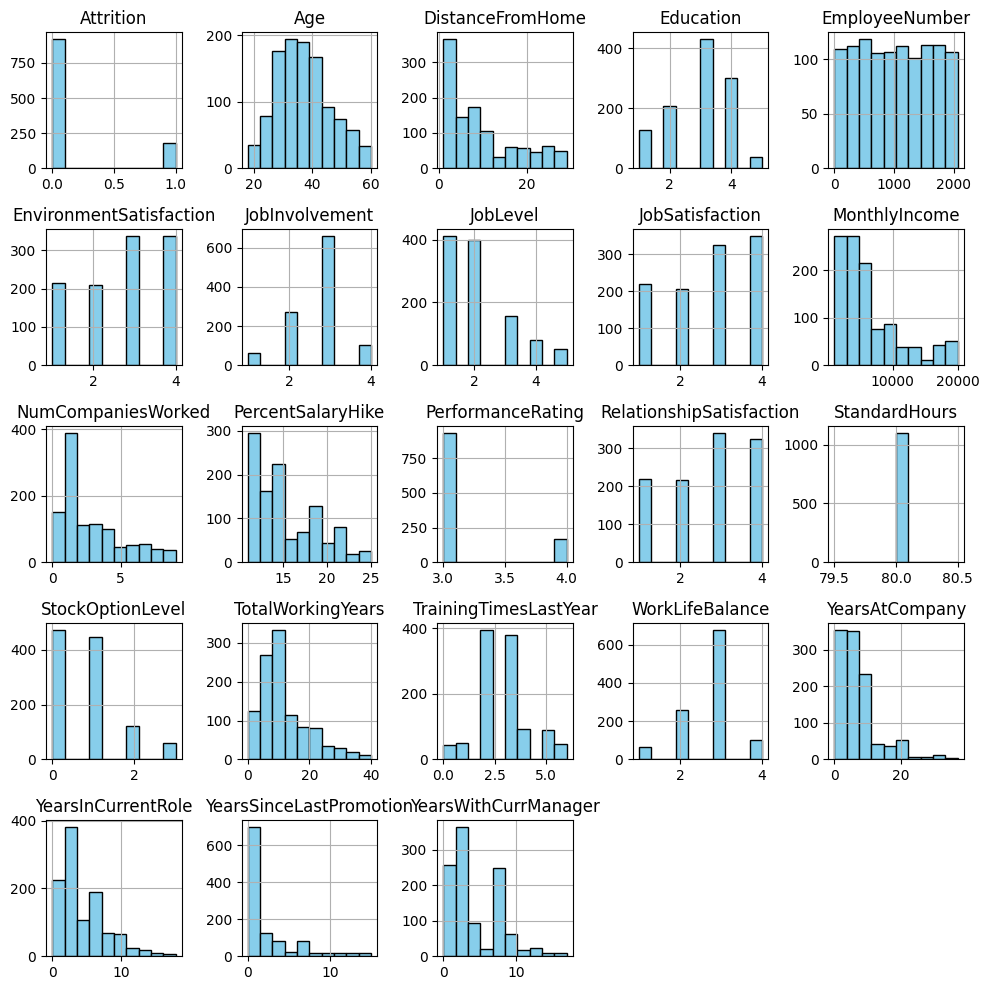

In [12]:
#绘制字符串频次直方图
num_cols.hist(
    figsize=(10, 10),
    edgecolor='black',
    color='skyblue'
)
plt.tight_layout()
plt.show()

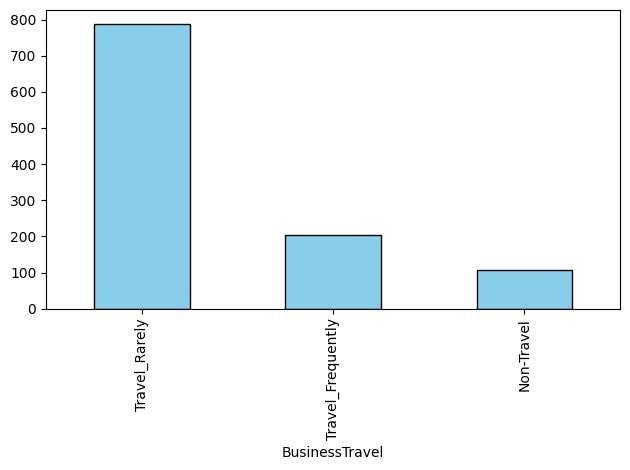

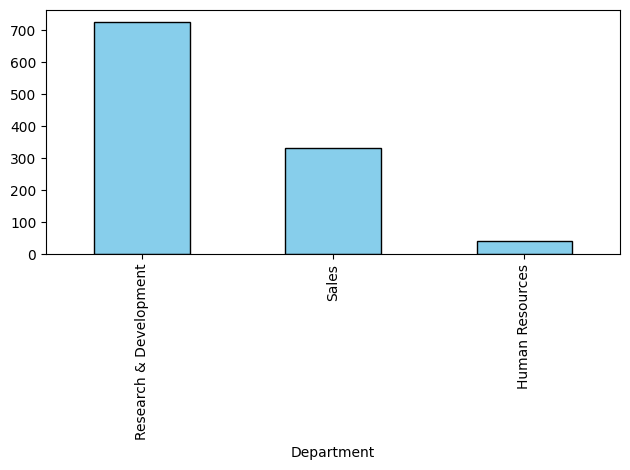

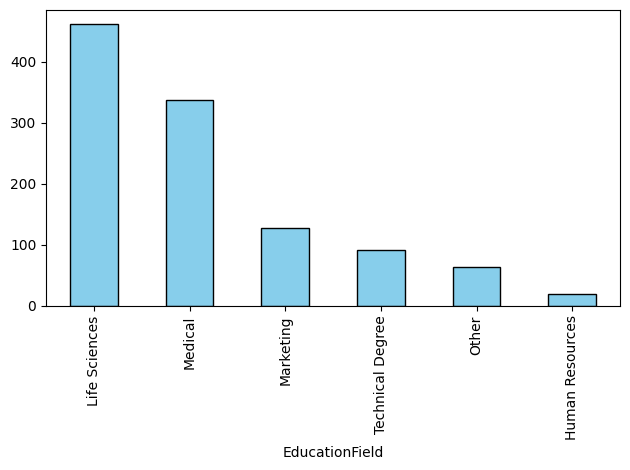

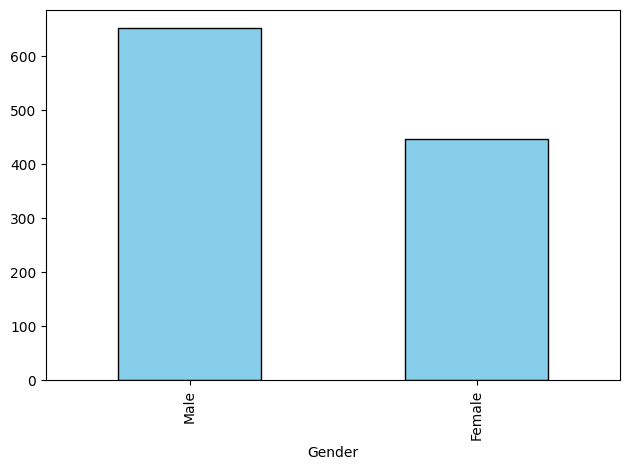

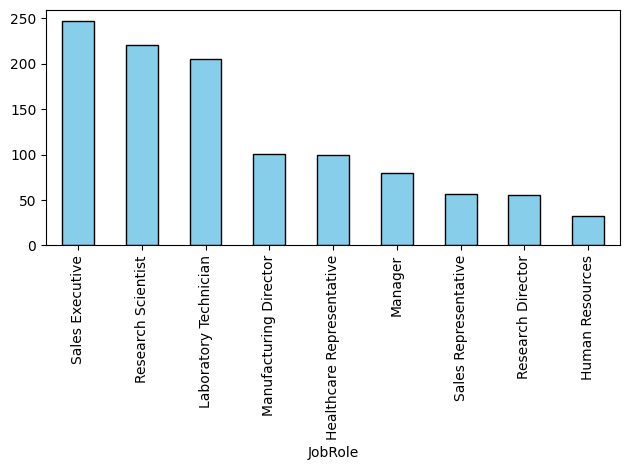

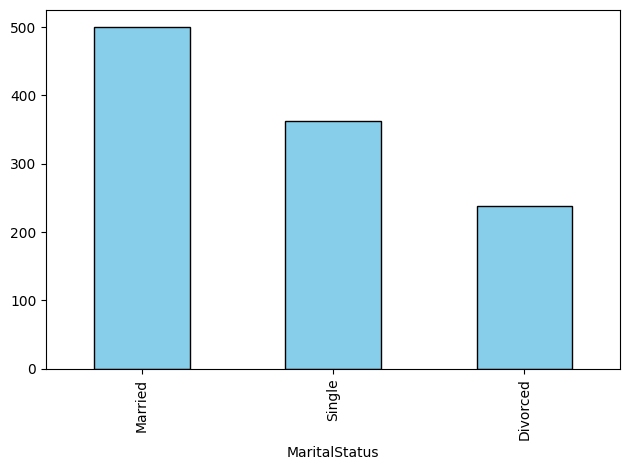

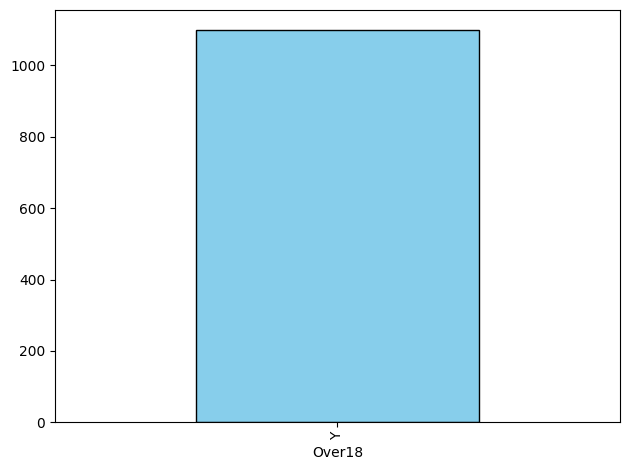

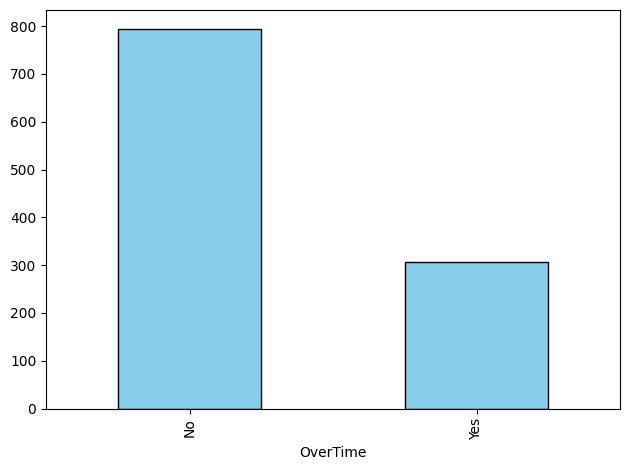

In [13]:
for col in str_cols:
    str_cols[col].value_counts().plot.bar(color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

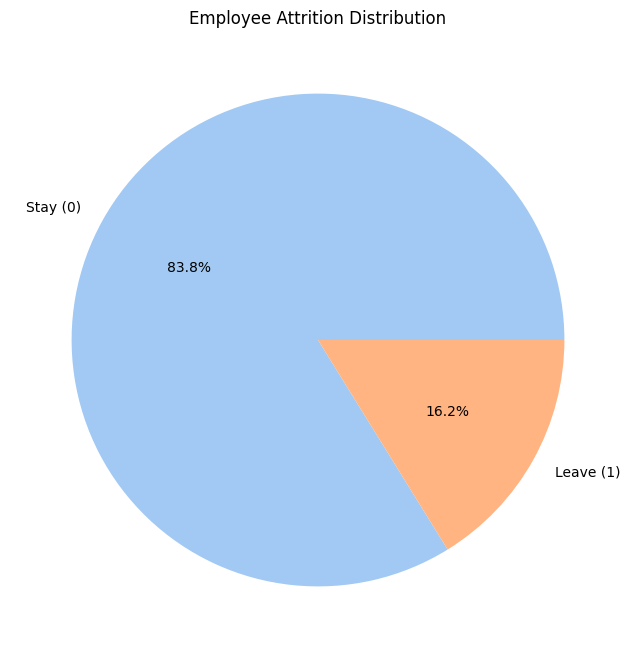

In [14]:
# 饼图
plt.figure(figsize=(8, 8))
plt.pie([922, 178],
        labels=['Stay (0)', 'Leave (1)'],
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'))

plt.title('Employee Attrition Distribution')
plt.show()
# 结论：离职人数较少，离职率为16.2%

In [18]:
# 去除冗余特征
df.drop(columns=['Over18',
                 'StandardHours',
                 'EmployeeNumber'], inplace=True)

<Axes: xlabel='Education', ylabel='count'>

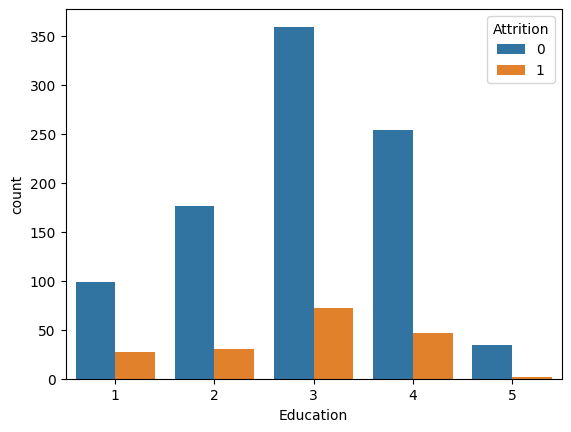

In [19]:
# 4、分析离职和受教育程度的分析
# 使用countplot方式进行分析
sns.countplot(x="Education", hue="Attrition", data=train_data)
# 结论：受教育程度为“大学”的离职人数较多，而“高中”的离职人数较少。

<Axes: xlabel='Attrition', ylabel='Age'>

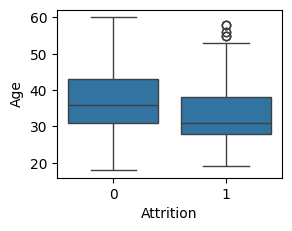

In [21]:
# 1.离职和年龄的关系
plt.subplot(221)
sns.boxplot(x="Attrition", y="Age", data=train_data)

<Axes: xlabel='Attrition', ylabel='DistanceFromHome'>

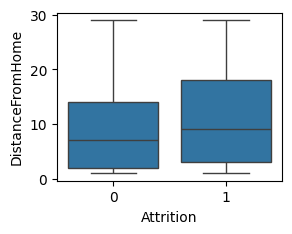

In [22]:
# 2.离职和家庭和距离之间的关系
plt.subplot(222)
sns.boxplot(x="Attrition", y="DistanceFromHome", data=train_data)

<Axes: xlabel='Attrition', ylabel='MonthlyIncome'>

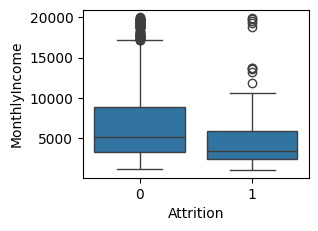

In [23]:
# 3.离职和月收入的关系
plt.subplot(223)
sns.boxplot(x="Attrition", y="MonthlyIncome", data=train_data)

<Axes: xlabel='Attrition', ylabel='NumCompaniesWorked'>

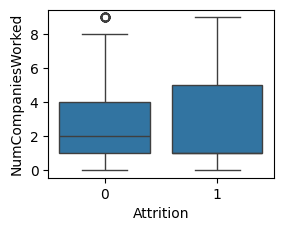

In [24]:
plt.subplot(224)
sns.boxplot(x="Attrition", y="NumCompaniesWorked", data=train_data)

<Axes: xlabel='Attrition', ylabel='count'>

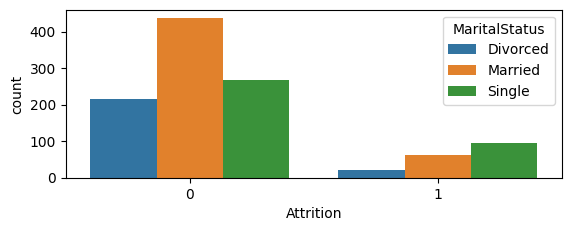

In [25]:
# 6、离职和婚姻状况、性别的关系
# 离职和婚姻状况分析
plt.subplot(2, 1, 1)
sns.countplot(x="Attrition", hue="MaritalStatus", data=train_data)

<Axes: xlabel='Attrition', ylabel='count'>

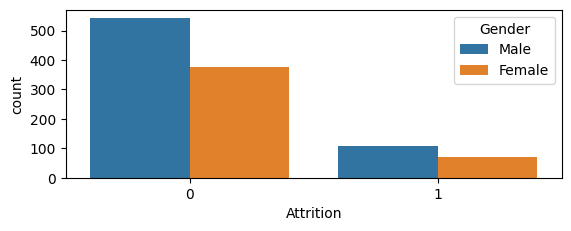

In [26]:
# 离职和性别关系
plt.subplot(2, 1, 2)
sns.countplot(x="Attrition", hue="Gender", data=train_data)

In [27]:
#  离职和性别的分组统计
train_data.groupby('Gender')['Attrition'].value_counts()

Gender  Attrition
Female  0            378
        1             69
Male    0            544
        1            109
Name: count, dtype: int64

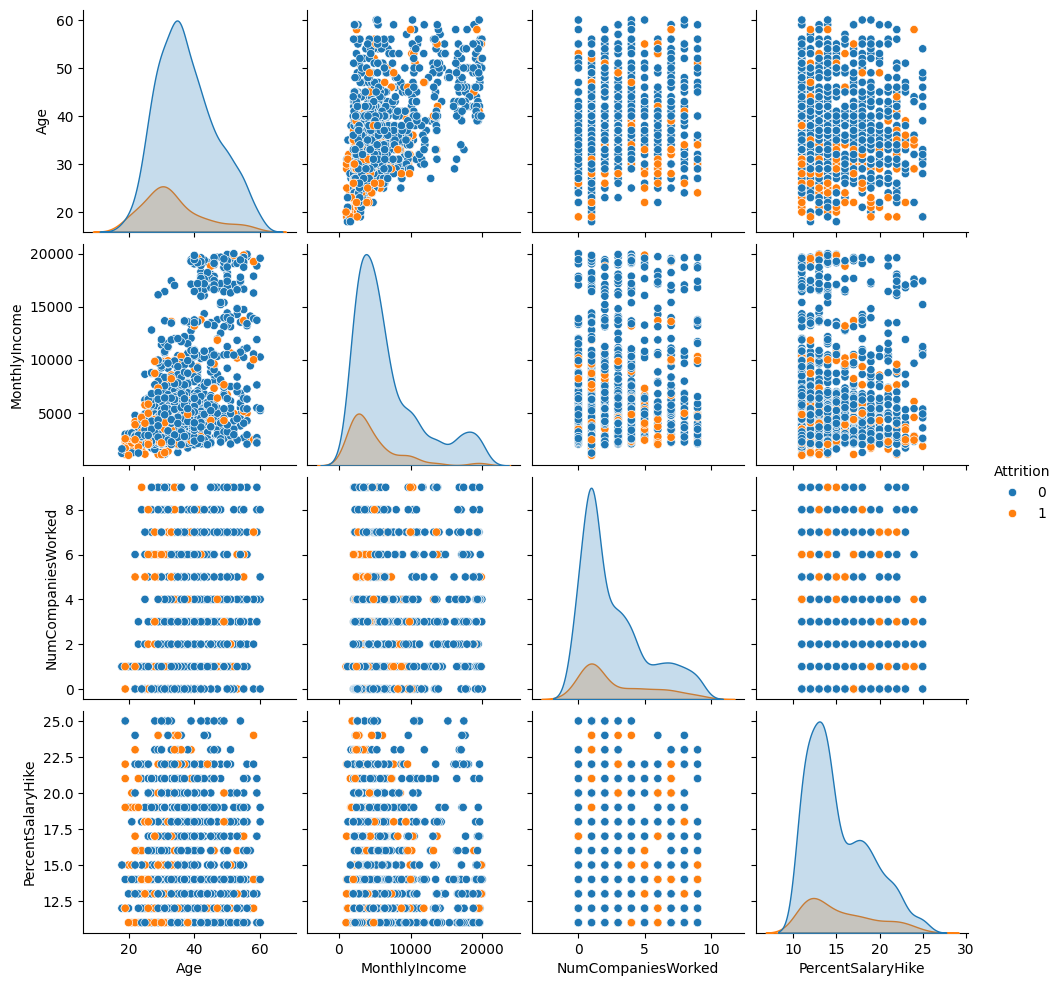

In [28]:
# 7、离职和其他变量的相关性分析
sns.pairplot(data=train_data, hue="Attrition", vars=["Age", "MonthlyIncome","NumCompaniesWorked", "PercentSalaryHike"])
# 结论：离职和年龄、家庭和距离、月收入、 previously worked 的关系，月收入越低的离职人数较多，而月收入较高的离职人数较少。

<Axes: xlabel='BusinessTravel', ylabel='Probability'>

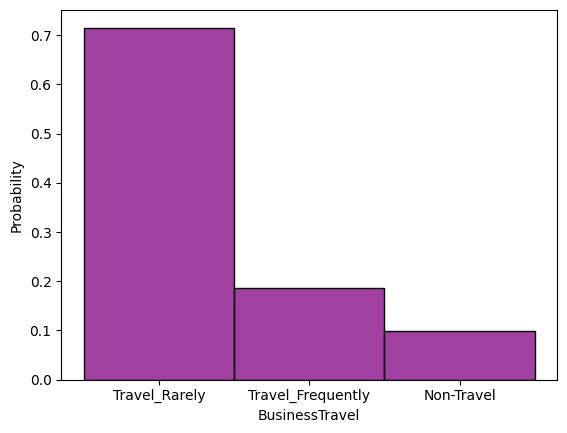

In [29]:
# 8、离职和商务旅行的关系
# sns.histplot(data=train_data, x='BusinessTravel', element='step', color='purple', stat='percent')
sns.histplot(data=train_data, x='BusinessTravel', element='bars', color='purple', stat='probability')
# 商务旅行直方图
# 可以看到大多数工作需要员工出差，但很少。大约20%的工作需要经常出差，10%没有出差。
# 结论：商务旅行对离职有影响，因为那些需要出差的人离职的概率较高。

<Axes: ylabel='DistanceFromHome'>

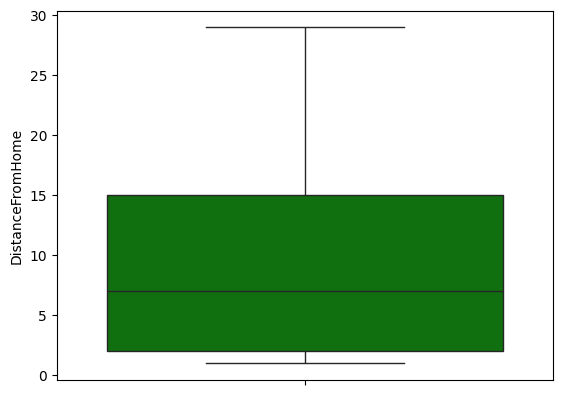

In [30]:
# 9、离职和距离的箱形图
sns.boxplot(data=train_data, y='DistanceFromHome', color='green')
# 离家的距离箱形图
# 从这个箱线图中，我们可以看到，员工平均要走7公里才能到达办公室，其中75%的员工要走1到14公里才能到达办公室。让我们看看离家的距离和损耗之间是否有任何关系
# 结论：离家的距离对离职有影响，因为那些离家较远的人离职的概率较高。

In [31]:
# 1-根据百分位数划分数据
cut_labels = ['Near', 'Reasonable', 'Far']
cut_bins = [-1, train_data['DistanceFromHome'].quantile(0.33), train_data['DistanceFromHome'].quantile(0.67), train_data['DistanceFromHome'].max() + 1]
train_data['DistanceGroup'] = pd.cut(train_data['DistanceFromHome'], bins=cut_bins, labels=cut_labels)

In [33]:
# 2.计算每组的退出概率
probabilities = train_data.groupby('DistanceGroup').apply(lambda group: sum(group['Attrition'] == 'Yes') / len(group)).reset_index()
probabilities.columns = ['DistanceGroup', 'Probability']
probabilities

,DistanceGroup,Probability
0,Near,0.0
1,Reasonable,0.0
2,Far,0.0


<Axes: xlabel='Education', ylabel='NumCompaniesWorked'>

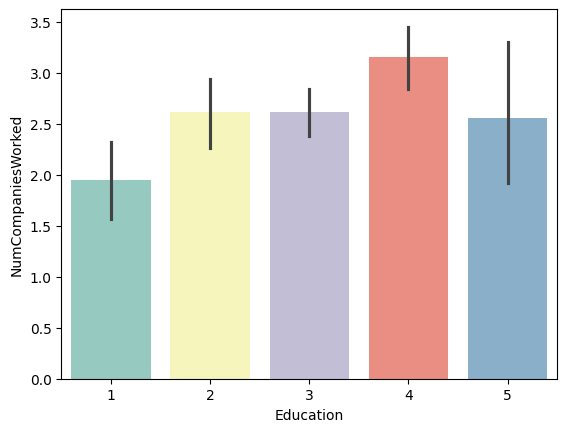

In [36]:
# 10、教育与工作过几家公司的关系
sns.barplot(data=train_data, y='NumCompaniesWorked', x='Education', palette='Set3')
# 上过高中的人换工作的频率较低。然而，拥有硕士学位的人更容易换工作
# 结论：学历对离职有影响，因为那些有博士学位的人离职的概率较高。

<Axes: xlabel='Age', ylabel='MonthlyIncome'>

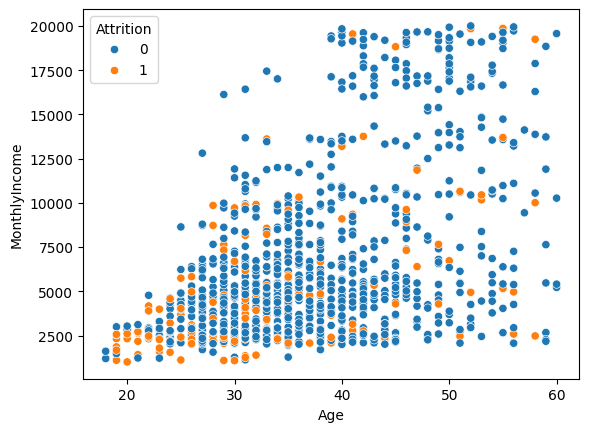

In [37]:
# 11、年龄和月收入散点图
sns.scatterplot(data=train_data, x='Age', y='MonthlyIncome', hue='Attrition')
# 从散点图中，我们可以看到，随着人们年龄的增长，高薪的机会越来越多，年长的雇员往往挣得更多，然而，工资差距也在扩大。
# 结论：年龄对离职有影响，因为那些年龄小的人离职的概率较高。

<Axes: xlabel='Age', ylabel='TotalWorkingYears'>

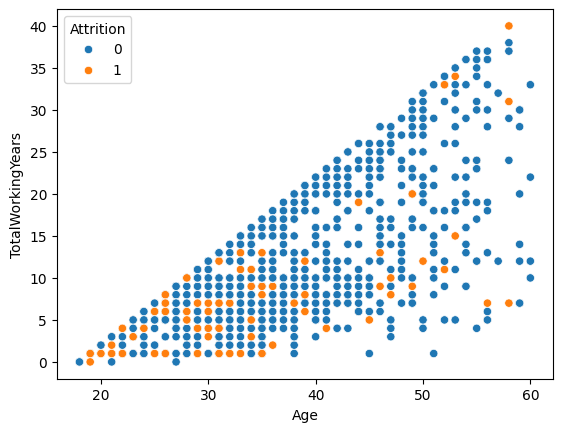

In [38]:
# 12、年龄和总工作年限的散点图
sns.scatterplot(data=train_data, x='Age', y='TotalWorkingYears', hue='Attrition')
# 结论：年从散点图来看，与经验丰富的同行相比，刚开始职业生涯的人通常更容易辞职

In [4]:
df.columns

Index(['Attrition', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

<Axes: xlabel='Attrition', ylabel='OverTime'>

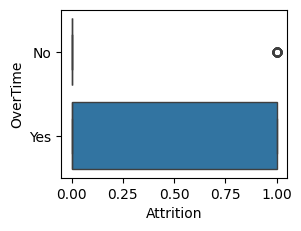

In [9]:
plt.subplot(224)
sns.boxplot(x="Attrition", y="OverTime", data=train_data)

<Axes: xlabel='Attrition', ylabel='count'>

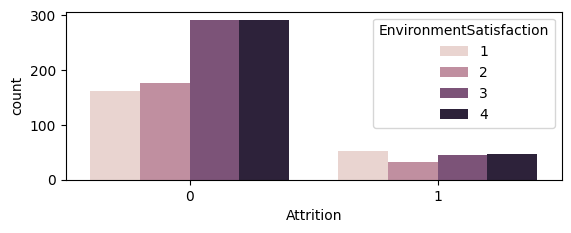

In [11]:
# 离职和性别关系
plt.subplot(2, 1, 2)
sns.countplot(x="Attrition", hue="EnvironmentSatisfaction", data=train_data)

In [ ]:
plt.subplot(2, 1, 2)
sns.countplot(x="Attrition", hue="StockOptionLevel", data=train_data)

## 四、特征工程

### 4.1 去除无意义的特征列

In [5]:
# 保存去除冗余特征后的数据集
df_original = df.copy()
df.to_pickle('df_original.pkl')

### 4.2 分离标签列，做独热编码（转为0-1）

In [6]:
# 加载数据集
#lead the data
df = load('df_original.pkl')

In [7]:
#标签列
Y = df['Attrition']
Y.head(30)

0     0
1     0
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    1
13    0
14    0
15    0
16    0
17    0
18    0
19    1
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
Name: Attrition, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
'''transform the cat data to num data for y '''
Y = pd.get_dummies(Y, columns=['Attrition'], drop_first=True)

In [9]:
#特征列
X = df.drop(columns='Attrition')
X

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,37,Travel_Rarely,Research & Development,1,4,Life Sciences,77,1,Male,2,...,3,80,1,7,2,4,7,5,0,7
1,54,Travel_Frequently,Research & Development,1,4,Life Sciences,1245,4,Female,3,...,1,80,1,33,2,1,5,4,1,4
2,34,Travel_Frequently,Research & Development,7,3,Life Sciences,147,1,Male,1,...,4,80,0,9,3,3,9,7,0,6
3,39,Travel_Rarely,Research & Development,1,1,Life Sciences,1026,4,Female,2,...,3,80,1,21,3,3,21,6,11,8
4,28,Travel_Frequently,Research & Development,1,3,Medical,1111,1,Male,2,...,1,80,2,1,2,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,35,Travel_Rarely,Research & Development,23,4,Medical,75,3,Female,3,...,3,80,1,4,3,3,2,2,2,2
1096,38,Travel_Rarely,Sales,2,4,Marketing,1835,2,Female,1,...,1,80,2,20,4,2,4,2,0,3
1097,37,Travel_Rarely,Sales,16,4,Marketing,868,4,Male,2,...,4,80,2,9,2,3,1,0,0,0
1098,22,Travel_Rarely,Research & Development,7,1,Life Sciences,1878,4,Male,3,...,1,80,0,1,2,3,1,0,0,0


In [10]:
df.columns

Index(['Attrition', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [11]:
# 选取的特征
choose_feature = ['Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance','YearsSinceLastPromotion']

In [12]:
# 与选取的特征取交集
X = X[X.columns.intersection(choose_feature)]
X = X[X.columns.intersection(choose_feature).tolist()]

In [13]:
# 保存
Y.to_pickle('Y.pkl')
X.to_pickle('X.pkl')

### 4.2 独热编码，有序编码，归一化特征划分

In [14]:
#无序字符型
nominal_cols = [
                    'BusinessTravel','Department','EducationField',
                    'Gender','JobRole','MaritalStatus','OverTime']

#有序字符型
ordinal_cols = [
                    'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
                    'JobLevel', 'JobSatisfaction', 'PerformanceRating',
                    'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

#数字连续型
continuous_cols = [
                    'Age','DistanceFromHome',
                    'MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                    'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
                    'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']



In [15]:
type(nominal_cols)

list

In [16]:
nominal_cols = list(set(nominal_cols) & set(choose_feature))
ordinal_cols = list(set(ordinal_cols) & set(choose_feature))
continuous_cols = list(set(continuous_cols) & set(choose_feature))
type(continuous_cols)

list

In [17]:
nominal_cols

['Department',
 'JobRole',
 'MaritalStatus',
 'Gender',
 'EducationField',
 'BusinessTravel',
 'OverTime']

### 4.3 数据转化

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols),
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('cont', StandardScaler(), continuous_cols)
    ],
).set_output(transform="pandas")

## 五、模型训练

### 5.1 划分数据集

In [20]:
# 加载数据文件
Y = load('Y.pkl')
X = load('X.pkl')

存在样本数据不均匀情况，要做样本均衡

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)

### 5.2 定义网格搜索超参

In [ ]:
param_grids = {
    'knn': {
        'clf__n_neighbors': [5, 9],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },

    'lr': {
        'clf__C': [0.03, 0.3, 3, 30],
        'clf__penalty': ['l2'],
        'clf__solver': ['liblinear'],
        'clf__class_weight': [None, 'balanced'],
        'clf__max_iter': [1000]
    },

    'dt': {
        'dt__min_samples_split': [4, 10, 20],
        'dt__min_samples_leaf': [2, 4, 8],
        'dt__max_depth': [3, 5, 7, None],
        'dt__criterion': ['gini', 'entropy'],
        'dt__class_weight': [None, 'balanced']
    },

    'rf': {
        'clf__n_estimators': [200],
        'clf__max_depth': [4, 6, 8, None],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features': ['sqrt', 0.7],
        'clf__class_weight': ['balanced', 'balanced_subsample']
    },

    'ada': {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.5, 1.0],
        'clf__algorithm': ['SAMME']
    },

    'gbdt': {
        'clf__n_estimators': [100, 150],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_depth': [2, 3, 4],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2],
        'clf__subsample': [0.8, 1.0]
    },

    'xgb': {
        'clf__n_estimators': [100, 150],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_depth': [2, 3, 4],
        'clf__min_child_weight': [1, 3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0]
    }
}

In [24]:
# 定义交叉验证策略
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 5.3 模型对比

In [34]:
# 定义最佳模型字典
optimized_learners = {}

#### 5.3.1 kNN 算法

In [36]:
knn =  ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf',  KNeighborsClassifier())])
knn_grid = GridSearchCV(knn, param_grids['knn'], cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
knn_grid.fit(X_train, y_train)

#加入字典
optimized_learners['knn'] = knn_grid.best_estimator_

print(f"KNN最佳参数: {knn_grid.best_params_}, 最佳得分: {knn_grid.best_score_:.4f}")

KNN最佳参数: {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}, 最佳得分: 0.7932


In [37]:
# 预测
best_knn = optimized_learners['knn']
y_pred  = best_knn.predict(X_test)
y_score = best_knn.predict_proba(X_test)[:, 1]

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.7455
F1       : 0.2821
AUC      : 0.5914
混淆矩阵:
[[153  31]
 [ 25  11]]
分类报告:
              precision    recall  f1-score   support

       False       0.86      0.83      0.85       184
        True       0.26      0.31      0.28        36

    accuracy                           0.75       220
   macro avg       0.56      0.57      0.56       220
weighted avg       0.76      0.75      0.75       220



<Figure size 600x500 with 0 Axes>

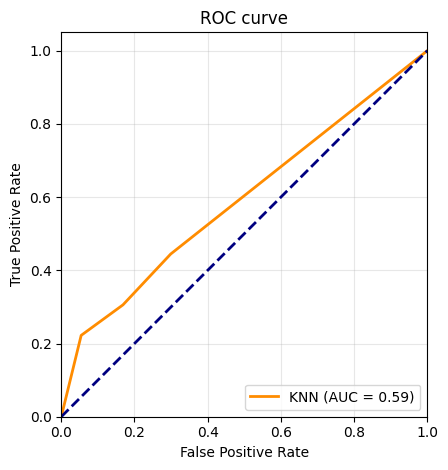

最佳参数: {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}, 最佳交叉验证得分: 0.7932, 测试集 AUC: 0.5914


In [38]:
# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='KNN').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"最佳参数: {knn_grid.best_params_}, "
      f"最佳交叉验证得分: {knn_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [39]:
# 1. 保存
save_dir = "../model"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_knn, os.path.join(save_dir, "best_knn.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\a\per_assessment1\model


#### 5.3.2 逻辑回归

In [40]:
lr = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf',  LogisticRegression())])
lr_grid = GridSearchCV(lr, param_grids['lr'], cv=cv, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train.values)

optimized_learners['lr'] = lr_grid.best_estimator_

print(f"逻辑回归最佳参数: {lr_grid.best_params_}, 最佳得分: {lr_grid.best_score_:.4f}")

逻辑回归最佳参数: {'clf__C': 0.03, 'clf__class_weight': None, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}, 最佳得分: 0.7727


In [85]:
# 预测
best_lr = optimized_learners['lr']
y_pred  = best_lr.predict(X_test)
y_score = best_lr.predict_proba(X_test)[:, 1]

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.8916
F1       : 0.8907
AUC      : 0.9588
混淆矩阵:
[[166  19]
 [ 21 163]]
分类报告:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       185
           1       0.90      0.89      0.89       184

    accuracy                           0.89       369
   macro avg       0.89      0.89      0.89       369
weighted avg       0.89      0.89      0.89       369



<Figure size 600x500 with 0 Axes>

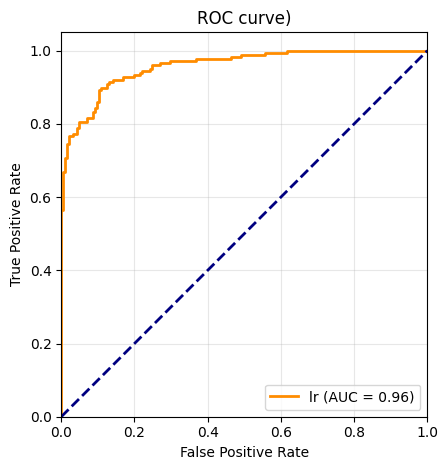

最佳参数: {'clf__C': 3, 'clf__class_weight': None, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}, 最佳交叉验证得分: 0.8773, 测试集 AUC: 0.9588


In [86]:
# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='lr').plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"最佳参数: {lr_grid.best_params_}, "
      f"最佳交叉验证得分: {lr_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [87]:
joblib.dump(best_lr, os.path.join(save_dir, "best_lr.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\a\data-mining\model


#### 5.3.3 决策树

In [ ]:
dt = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('dt', DecisionTreeClassifier())
])

dt_grid = GridSearchCV(dt, param_grids['dt'], cv=cv, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

optimized_learners['dt'] = dt_grid.best_estimator_

print(f"决策树最佳参数: {dt_grid.best_params_}, 最佳得分: {dt_grid.best_score_:.4f}")

决策树最佳参数: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 4}, 最佳得分: 0.8034


In [ ]:
# 预测
best_dt = optimized_learners['dt'] 
y_pred  = best_dt.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.7859
F1       : 0.7824
AUC      : 0.9204
混淆矩阵:
[[148  37]
 [ 42 142]]
分类报告:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       185
           1       0.79      0.77      0.78       184

    accuracy                           0.79       369
   macro avg       0.79      0.79      0.79       369
weighted avg       0.79      0.79      0.79       369



<Figure size 600x500 with 0 Axes>

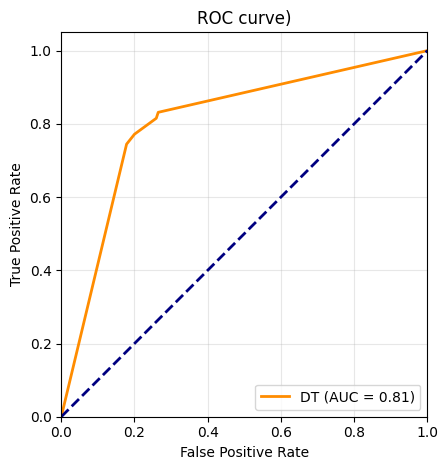

KNN 最佳参数: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 4}, 最佳交叉验证得分: 0.8034, 测试集 AUC: 0.8076


In [ ]:
# 1. 用最优模型在测试集上预测概率         # GridSearchCV 的最佳估计器
y_score = best_dt.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='DT').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"KNN 最佳参数: {dt_grid.best_params_}, "
      f"最佳交叉验证得分: {dt_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [ ]:
joblib.dump(best_dt, os.path.join(save_dir, "best_dt.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


#### 5.3.4 随机森林

In [ ]:
rf = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid = GridSearchCV(rf, param_grids['rf'], cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

optimized_learners['rf'] = rf_grid.best_estimator_

print(f"随机森林最佳参数: {rf_grid.best_params_}, 最佳得分: {rf_grid.best_score_:.4f}")

随机森林最佳参数: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, 最佳得分: 0.9173


In [ ]:
# 预测
best_rf = optimized_learners['rf'] 
y_pred  = best_rf.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9187
F1       : 0.9185
AUC      : 0.9204
混淆矩阵:
[[170  15]
 [ 15 169]]
分类报告:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       185
           1       0.92      0.92      0.92       184

    accuracy                           0.92       369
   macro avg       0.92      0.92      0.92       369
weighted avg       0.92      0.92      0.92       369



<Figure size 600x500 with 0 Axes>

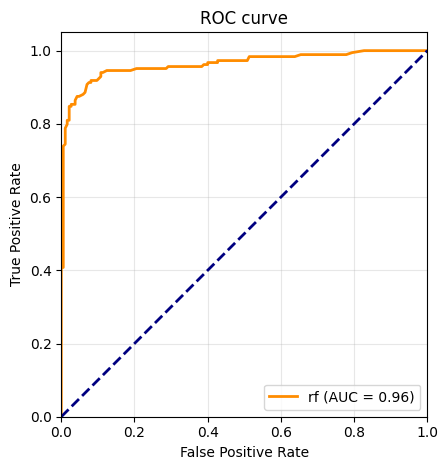

KNN 最佳参数: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, 最佳交叉验证得分: 0.9173, 测试集 AUC: 0.9627


In [ ]:
# 1. 用最优模型在测试集上预测概率         # GridSearchCV 的最佳估计器
y_score = best_rf.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='rf').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"KNN 最佳参数: {rf_grid.best_params_}, "
      f"最佳交叉验证得分: {rf_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [149]:
joblib.dump(best_rf, os.path.join(save_dir, "best_rf.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


#### 5.3.5 Adaboost

In [ ]:
ada = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', AdaBoostClassifier(random_state=42))
])

ada_grid = GridSearchCV(ada, param_grids['ada'], cv=cv, scoring='accuracy', n_jobs=-1)
ada_grid.fit(X_train, y_train)

optimized_learners['ada'] = ada_grid.best_estimator_

print(f"AdaBoost最佳参数: {ada_grid.best_params_}, 最佳得分: {ada_grid.best_score_:.4f}")

AdaBoost最佳参数: {'clf__algorithm': 'SAMME', 'clf__learning_rate': 1.0, 'clf__n_estimators': 100}, 最佳得分: 0.8549


In [ ]:
# 预测
best_ada = optimized_learners['ada']
y_pred  = best_ada.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.8835
F1       : 0.8822
AUC      : 0.9204
混淆矩阵:
[[165  20]
 [ 23 161]]
分类报告:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       185
           1       0.89      0.88      0.88       184

    accuracy                           0.88       369
   macro avg       0.88      0.88      0.88       369
weighted avg       0.88      0.88      0.88       369



<Figure size 600x500 with 0 Axes>

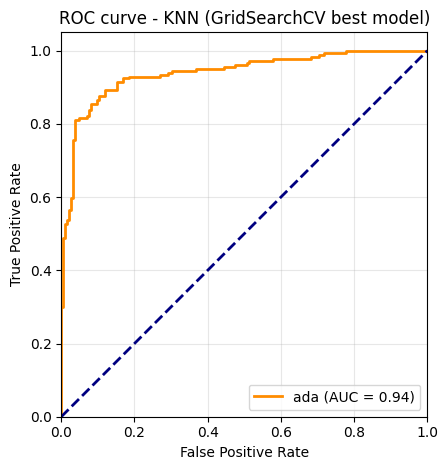

KNN 最佳参数: {'clf__algorithm': 'SAMME', 'clf__learning_rate': 1.0, 'clf__n_estimators': 100}, 最佳交叉验证得分: 0.8549, 测试集 AUC: 0.9403


In [ ]:
# 1. 用最优模型在测试集上预测概率          # GridSearchCV 的最佳估计器
y_score = best_ada.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='ada').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"KNN 最佳参数: {ada_grid.best_params_}, "
      f"最佳交叉验证得分: {ada_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [151]:
joblib.dump(best_ada, os.path.join(save_dir, "best_ada.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


#### 5.3.6 梯度提升决策树

In [ ]:
gbdt = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

gbdt_grid = GridSearchCV(gbdt, param_grids['gbdt'], cv=cv, scoring='accuracy', n_jobs=-1)
gbdt_grid.fit(X_train, y_train)

optimized_learners['gbdt'] = gbdt_grid.best_estimator_

print(f"梯度提升最佳参数: {gbdt_grid.best_params_}, 最佳得分: {gbdt_grid.best_score_:.4f}")

梯度提升最佳参数: {'clf__learning_rate': 0.2, 'clf__max_depth': 4, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 150, 'clf__subsample': 0.8}, 最佳得分: 0.9098


In [ ]:
# 预测
best_gbdt = optimized_learners['gbdt']  
y_pred  = best_gbdt.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9214
F1       : 0.9197
AUC      : 0.9204
混淆矩阵:
[[174  11]
 [ 18 166]]
分类报告:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       185
           1       0.94      0.90      0.92       184

    accuracy                           0.92       369
   macro avg       0.92      0.92      0.92       369
weighted avg       0.92      0.92      0.92       369



<Figure size 600x500 with 0 Axes>

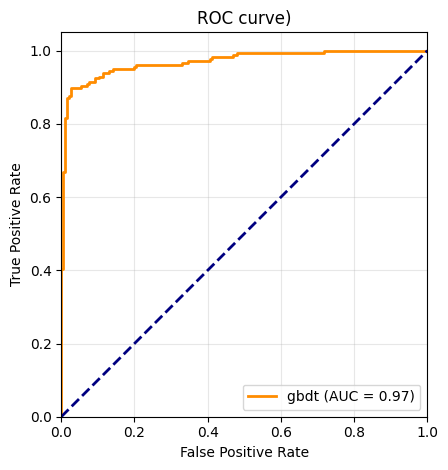

KNN 最佳参数: {'clf__learning_rate': 0.2, 'clf__max_depth': 4, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 150, 'clf__subsample': 0.8}, 最佳交叉验证得分: 0.9098, 测试集 AUC: 0.9707


In [218]:
# 1. 用最优模型在测试集上预测概率
best_gbdt = optimized_learners['gbdt']          # GridSearchCV 的最佳估计器
y_score = best_gbdt.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='gbdt').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"KNN 最佳参数: {gbdt_grid.best_params_}, "
      f"最佳交叉验证得分: {gbdt_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [152]:
joblib.dump(best_gbdt, os.path.join(save_dir, "best_gbdt.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


#### 5.3.7 XGboosting

In [ ]:
xgb = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', xgb.XGBClassifier())
])

xgb_grid = GridSearchCV(xgb, param_grids['xgb'], cv=cv, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

optimized_learners['xgb'] = xgb_grid.best_estimator_

print(f"xgb最佳参数: {xgb_grid.best_params_}, 最佳得分: {xgb_grid.best_score_:.4f}")

xgb最佳参数: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 150, 'clf__subsample': 0.8}, 最佳得分: 0.9044


In [ ]:
# 预测
best_xgb = optimized_learners['xgb']
y_pred  = best_xgb.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.8171
F1       : 0.4182
AUC      : 0.7723
混淆矩阵:
[[263  34]
 [ 30  23]]
分类报告:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       297
           1       0.40      0.43      0.42        53

    accuracy                           0.82       350
   macro avg       0.65      0.66      0.65       350
weighted avg       0.82      0.82      0.82       350



<Figure size 600x500 with 0 Axes>

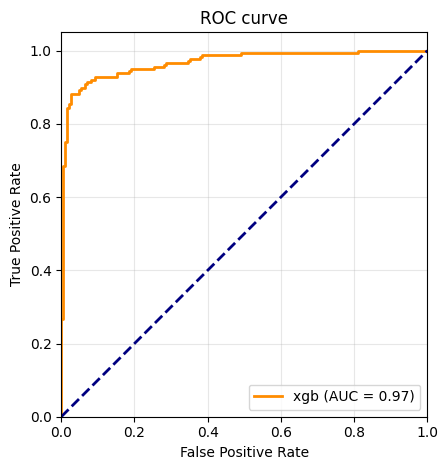

KNN 最佳参数: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 150, 'clf__subsample': 0.8}, 最佳交叉验证得分: 0.9044, 测试集 AUC: 0.9681


In [ ]:
# 1. 用最优模型在测试集上预测概率       # GridSearchCV 的最佳估计器
y_score = best_xgb.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='xgb').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"KNN 最佳参数: {xgb_grid.best_params_}, "
      f"最佳交叉验证得分: {xgb_grid.best_score_:.4f}, "
      f"测试集 AUC: {roc_auc:.4f}")

In [153]:
joblib.dump(best_xgb, os.path.join(save_dir, "best_xgb.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


### 5.4 构建堆叠分类器

In [138]:
# 创建基础学习器列表
base_learners = [
    ('knn', optimized_learners['knn']),
    ('lr', optimized_learners['lr']),
    ('dt', optimized_learners['dt']),
    ('rf', optimized_learners['rf']),
    ('ada', optimized_learners['ada']),
    ('gbdt', optimized_learners['gbdt']),
    ('xgb', optimized_learners['xgb'])
]

In [ ]:
# 元学习器超参数优化
meta_param_grid = {
    'metal__C': [0.01, 0.1, 1, 10, 100],
    'metal__penalty': ['l1', 'l2'],
    'metal__solver': ['liblinear', 'saga'],
    'metal__class_weight': ['balanced', None]
}

meta_learner = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('metal', LogisticRegression())
])

meta_grid = GridSearchCV(meta_learner, meta_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

meta_grid.fit(X_train, y_train)

best_meta_learner = meta_grid.best_estimator_

print(f"元学习器最佳参数: {meta_grid.best_params_}, 最佳得分: {meta_grid.best_score_:.4f}")


元学习器最佳参数: {'metal__C': 0.1, 'metal__class_weight': None, 'metal__penalty': 'l2', 'metal__solver': 'saga'}, 最佳得分: 0.8529


In [220]:
final_classifier = best_meta_learner.named_steps['metal']  # 提取简单分类器
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_classifier,  # 使用简单分类器
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    stack_method='predict_proba'
)
stacking_model.fit(X_train, y_train)

,estimators,"[('knn', ...), ('lr', ...), ...]"
,final_estimator,LogisticRegre...solver='saga')
,cv,StratifiedKFo... shuffle=True)
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,0
,transformers,"[('nom', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None


## 5. 最终模型评估

In [223]:
y_pred = stacking_model.predict(X_test)
y_pred_proba = stacking_model.predict_proba(X_test)
if hasattr(y_pred_proba, 'shape') and len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
    y_pred_proba = y_pred_proba[:, 1]
else:
    y_pred_proba = np.array(y_pred_proba).ravel()

# 计算评估指标
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("最终模型性能")
print(f"准确率: {accuracy:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

最终模型性能
准确率: 0.9268
F1分数: 0.9248
AUC: 0.9772
混淆矩阵:
[[176   9]
 [ 18 166]]
分类报告:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       185
           1       0.95      0.90      0.92       184

    accuracy                           0.93       369
   macro avg       0.93      0.93      0.93       369
weighted avg       0.93      0.93      0.93       369



<Figure size 600x500 with 0 Axes>

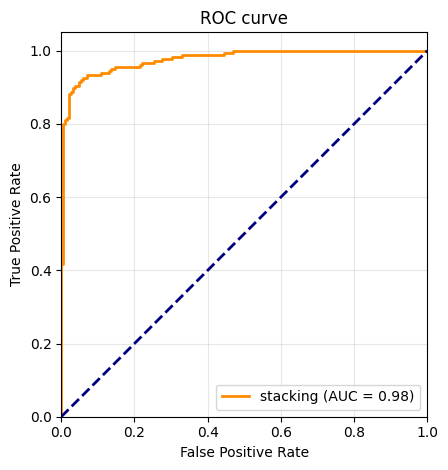

测试集 AUC: 0.9772


In [224]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

y_pred = stacking_model.predict(X_test)
# 1. 用最优模型在测试集上预测概率      # GridSearchCV 的最佳估计器
y_score = stacking_model.predict_proba(X_test)[:, 1]  # 取正类概率

# 2. 计算 FPR、TPR、AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score) 
# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='stacking').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"测试集 AUC: {roc_auc:.4f}")

In [172]:
joblib.dump(stacking_model, os.path.join(save_dir, "stacking.pkl"))
print("模型已保存到:", os.path.abspath(save_dir))

模型已保存到: c:\Users\rong\OneDrive\Desktop\BHcomp2025\homework\assessment1\data-mining\model


## 模拟实战

In [187]:
names = os.listdir(r'../model')
file_names = [f for f in names if os.path.isfile(os.path.join('../model', f))]
file_names

['best_ada.pkl',
 'best_dt.pkl',
 'best_gbdt.pkl',
 'best_knn.pkl',
 'best_lr.pkl',
 'best_rf.pkl',
 'best_xgb.pkl',
 'stacking.pkl']

In [188]:
loaded_model = joblib.load(os.path.join("../model", "best_xgb.pkl"))

In [192]:
# load test data
test_data = pd.read_csv('../data/test2.csv')
df_test = pd.DataFrame(test_data)

X_test = df_test.drop(columns=['Attrition'])
y_test = df_test['Attrition']

<Figure size 600x500 with 0 Axes>

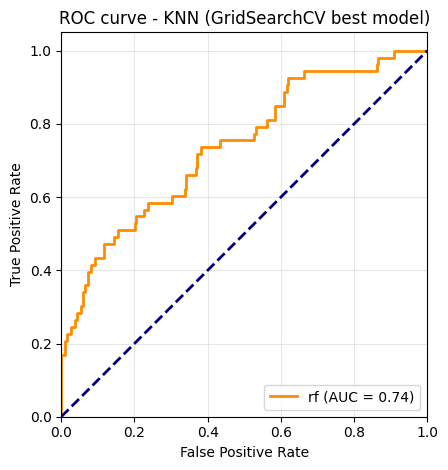

测试集 AUC: 0.7379


In [197]:
loaded_model = joblib.load(os.path.join("../model", "stacking.pkl"))

y_pred = loaded_model.predict(X_test)

# 预测概率
y_score = loaded_model.predict_proba(X_test)[:, 1]

# 2. 计算 FPR、TPR、AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score) 

# 3. 绘图
plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='rf').plot(color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - KNN (GridSearchCV best model)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 把之前的结果也一起打印
print(f"测试集 AUC: {roc_auc:.4f}")

In [181]:
# 预测
y_pred  = loaded_model.predict(X_test)

# 3. 计算指标
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 4. 打印
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")
print(f"混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print(f"分类报告:")
print(classification_report(y_test, y_pred))

Accuracy : 0.8171
F1       : 0.4182
AUC      : 0.7723
混淆矩阵:
[[263  34]
 [ 30  23]]
分类报告:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       297
           1       0.40      0.43      0.42        53

    accuracy                           0.82       350
   macro avg       0.65      0.66      0.65       350
weighted avg       0.82      0.82      0.82       350

